Can I design a filter using a 2D spectral stack and then convert it to a 3D spectrum for application?

In [21]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from numpy.fft import fft, fft2, ifft2, fftshift, ifftshift, fftn, ifftn

from scipy.ndimage import gaussian_filter, label

import skimage.morphology as morph
from skimage.measure import label

import timeit

Load some sample data:

In [2]:
#The data file used for algo development
devfile = "../images_and_data/F3_original_subvolume_IL230-430_XL475-675_T200-1800.npy"

#Load it
data = np.load(devfile)

print("Data shape:" + str(data.shape))

Data shape:(201, 201, 401)


In [53]:
def seismic_view(data, slices):
    # find 99th percentile of amplitude for plot scaling
    amp = np.percentile(data, 99.9)

    # Plot the 3D data
    atts = plt.figure(figsize=(10,7))

    XL, IL, T = slices

    # Look at XL
    ax1 = atts.add_subplot(141)
    ax1.imshow(data[:,XL,:].T, cmap="gray",vmin=-amp, vmax=amp, aspect='auto')
    #ax1.xaxis.tick_top()
    ax1.set_title('example xline')
    ax1.set_xlabel('inline')
    ax1.set_ylabel('time')

    # Look at IL
    ax1 = atts.add_subplot(142)
    ax1.imshow(data[IL,:,:1000].T, cmap="gray",vmin=-amp, vmax=amp, aspect='auto')
    #ax1.xaxis.tick_top()
    ax1.set_title('example inline')
    ax1.set_xlabel('xline')

    # Look at T index 100
    ax1 = atts.add_subplot(122)
    ax1.imshow(data[:,:,T].T, extent=(230, 430, 475, 675), cmap="gray",vmin=-amp, vmax=amp, aspect='1') # I didn't plot the Transpose here
    ax1.set_title('example timeslice')
    ax1.set_xlabel('inline')
    ax1.set_ylabel('xline');

def plot_spectra(spec, traces):
    
    amp = np.percentile(spec, 99.9)
    
    XL, IL, T = traces
    
    atts = plt.figure(figsize=(10, 7))

    # Look at "XL" index 50
    ax1 = atts.add_subplot(141)
    ax1.imshow(spec[:,XL,:].T, cmap="gray",vmin=0, vmax=amp)
    ax1.axhline(T, color='red')
    ax1.axvline(IL, color='red')

    # Look at "IL" index 50
    ax1 = atts.add_subplot(142)
    ax1.imshow(spec[IL,:,:].T, cmap="gray",vmin=0, vmax=amp)
    ax1.axhline(T, color='red')
    ax1.axvline(XL, color='red')

    # Look at "T" index 150
    ax1 = atts.add_subplot(122)
    ax1.imshow(spec[:,:,T].T, cmap="gray",vmin=0, vmax=amp)
    ax1.axhline(XL, color='red')
    ax1.axvline(IL, color='red');

Look at the seismic data:

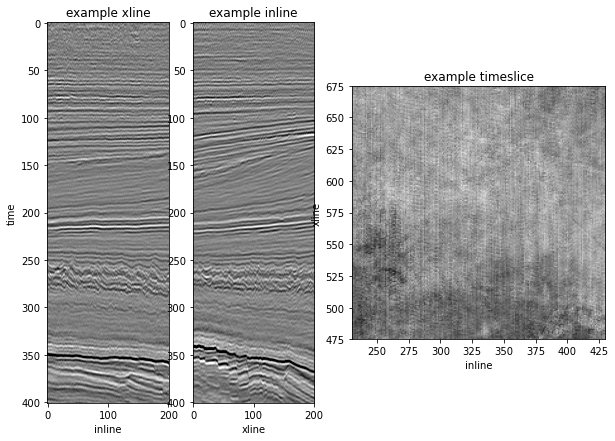

In [31]:
seismic_view(data, [100,100,60])

Calculate the stack of 2D spectra, then examine:

In [32]:
# Compute 2D spectra stack:
FS2D = np.zeros_like(data) # initialize 3D array

for i in range(data.shape[-1]): # For each slice of array...
    FS2D[:,:,i] = np.abs(fftshift(fft2(data[:,:,i]))) # ... populate with 2D spectrum

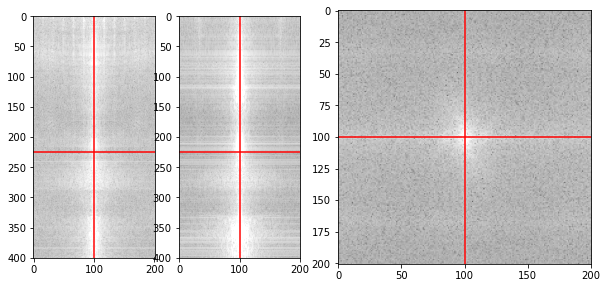

In [54]:
plot_spectra(np.log(FS2D), [100,100,225])

Design a filter

In [7]:
FS2D_filter = np.zeros_like(data)

# Eyeballing a filter to address high-frequency lineations
FS2D_filter[:,28:38,:230] = 1
FS2D_filter[:,162:172,:230] = 1

# Convolve with a gaussian filter:
FS2D_filter = gaussian_filter(FS2D_filter, [3,3,3])

# Scale to 1:
FS2D_filter = FS2D_filter/np.max(FS2D_filter)

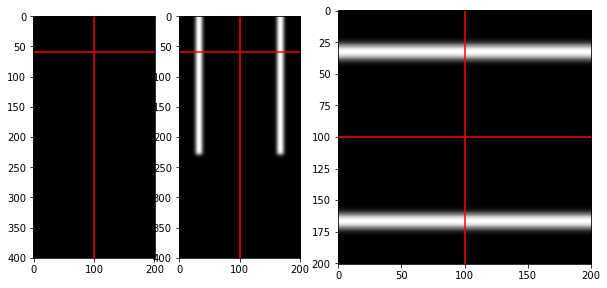

In [55]:
plot_spectra(FS2D_filter, [100,100,60])

### Apply as 2D filters:

In [9]:
def apply_2D_filter(data, filt, filter_strength=1.0):
    
    # Initialize output array
    out = np.zeros_like(data)

    for i in range(data.shape[2]):
        
        fs = fft2(data[:,:,i])
        
        filtered_fs = np.multiply(1 - (filter_strength * ifftshift(filt[:,:,i])),
                                  fs)

        out[:,:,i] = np.real(ifft2(filtered_fs))
        
    return out

In [10]:
starttime = timeit.default_timer()

data_2Dfiltered = apply_2D_filter(data, FS2D_filter, filter_strength=0.55)


print("Time taken:", timeit.default_timer() - starttime)


# Compute 2D spectra stack of new filtered data:
FS_2Dfiltered = np.zeros_like(data) # initialize 3D array

for i in range(data.shape[-1]): # For each slice of array...
    FS_2Dfiltered[:,:,i] = np.abs(fftshift(fft2(data_2Dfiltered[:,:,i]))) # ... populate with 2D spectrum

Time taken: 2.2144052090000006


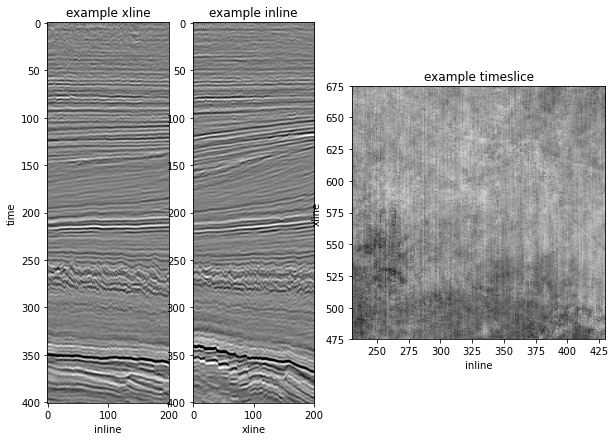

In [11]:
seismic_view(data_2Dfiltered, [100,100,60])

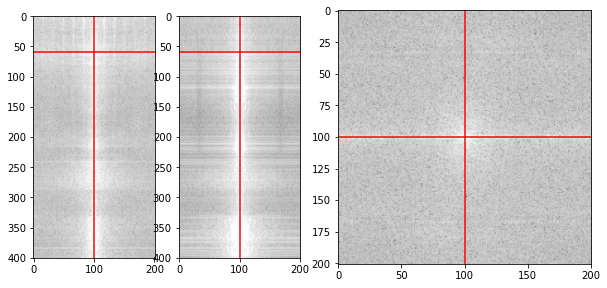

In [56]:
plot_spectra(np.log(FS_2Dfiltered), [100,100,60])

### Convert 2D spectral stack of filter into 3D spectrum and apply to data

In [144]:
# Regenerate the FS2D_filter

FS2D_filter = np.zeros_like(data)

# Eyeballing a filter to address high-frequency lineations
FS2D_filter[:,28:38,:230] = 1
FS2D_filter[:,162:172,:230] = 1


# Then, shift the spectra into their natural positions:

FS2D_filter_shift = np.copy(FS2D_filter)

for i in range(FS2D_filter.shape[2]):
    FS2D_filter_shift[:,:,i] = ifftshift(FS2D_filter_shift[:,:,i])
    
# Then calculate the 1D FFT along the z axis:
FS2D3D_filter = fft(FS2D_filter_shift, axis=2)

# Convolve with a gaussian filter
FS2D3D_filter = gaussian_filter(FS2D3D_filter, [3,3,3])

# Normalize to 1:
FS2D3D_filter = FS2D3D_filter/np.max(FS2D3D_filter)

(this didn't produce results like I thought... perhaps I should have transformed the 2D spectral stack filter back into the data domain and then generated the 3D spectrum?)

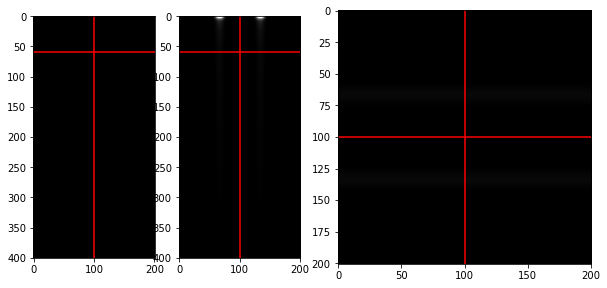

In [145]:
plot_spectra(np.real(FS2D3D_filter), [100,100,60])

In [146]:
def apply_3D_filter(data, filt, filter_strength=1.0):
    
    # Initialize output array
    out = np.real(ifftn(np.multiply(1 - (filter_strength * filt), fftn(data))))
        
    return out

Apply 3D filter to data:

In [189]:
starttime = timeit.default_timer()

data_2D3Dfiltered = apply_3D_filter(data, FS2D3D_filter, filter_strength=30.0)

print("Time taken:", timeit.default_timer() - starttime)


# Compute 2D spectra stack of new filtered data:
FS_2D3Dfiltered = np.zeros_like(data) # initialize 3D array

for i in range(data.shape[-1]): # For each slice of array...
    FS_2D3Dfiltered[:,:,i] = np.abs(fftshift(fft2(data_2D3Dfiltered[:,:,i]))) # ... populate with 2D spectrum

Time taken: 3.2580843340001593


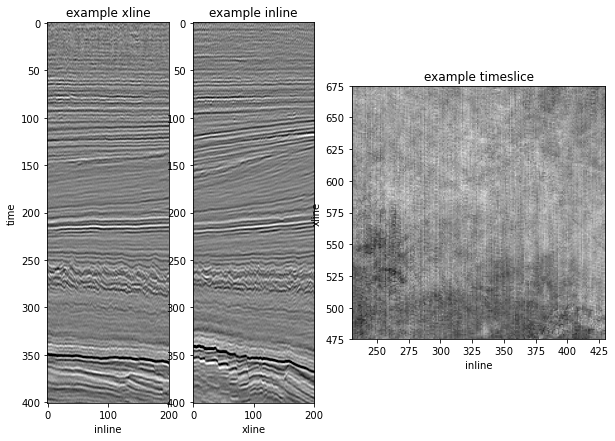

In [190]:
seismic_view(data_2D3Dfiltered, [100,100,60])

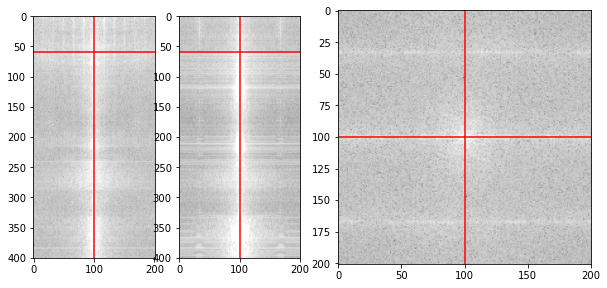

In [191]:
plot_spectra(np.log(FS_2D3Dfiltered), [100,100,60])

### Summary

Two things of note here:
1. Applying a filter as a 2D spectral stack (via for loop) is faster than applying a 3D filter by 33%
2. Designing a filter on 2D spectral stack and then applying the 1D FFT to the time domain didn't exactly work as I hoped. I suggested an alternative above.

